<a href="https://colab.research.google.com/github/rafaellopezgarcia/colab_notebooks/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 39.01 MiB/s, done.
Resolving deltas: 100% (3/3), done.


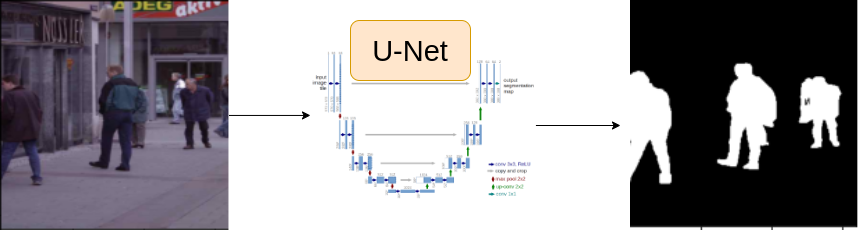

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_FILE = "/content/Human-Segmentation-Dataset-master/train.csv"
DATA_DIR = "content"

DEVICE = "cuda"

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"


In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

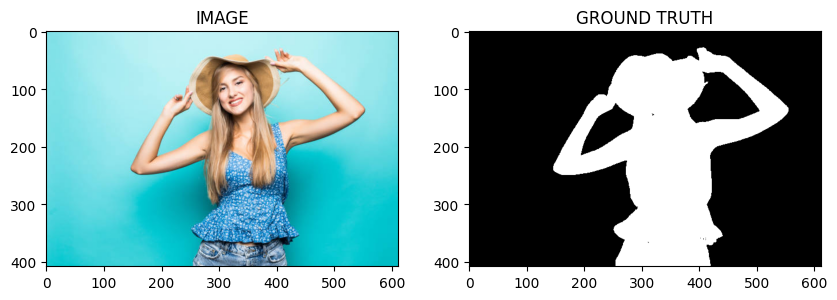

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)

  ],is_check_shapes=False)

def get_val_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)

  ],is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c)
    mask = np.expand_dims(mask, axis=-1)
    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, w, h)
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) /255.0)

    return image, mask

In [14]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_val_augs())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


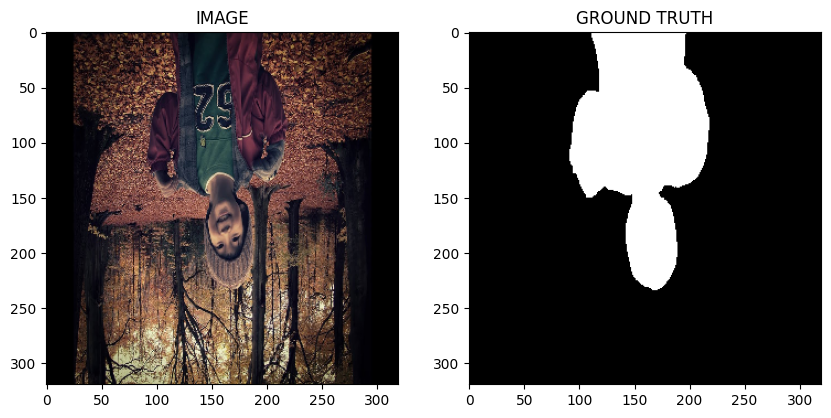

In [16]:
idx = 21

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [19]:
print(f"Total number of batches in trainloader: {len(trainloader)}")
print(f"Total number of batches in validloader: {len(validloader)}")

Total number of batches in trainloader: 15
Total number of batches in validloader: 4


In [20]:
for image, mask in trainloader:
  break

print(f"One batch image shape: {image.shape}")
print(f"One batch mask shape: {mask.shape}")

One batch image shape: torch.Size([16, 3, 320, 320])
One batch mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [21]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [22]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode="binary")(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2

    return logits

In [23]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 97.1MB/s]


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [25]:
def train_fn(data_loader, model, optimizer):
  model.train() ## Model uses dropout and batchnorm layers

  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [24]:
def eval_fn(data_loader, model):
  model.eval() ## Model does not use dropout layers

  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss= model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [27]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("SAVED MODEL")
    best_valid_loss = valid_loss

  print(f"Epoch: {i+1} Train loss: {train_loss}, Valid loss: {valid_loss}")

 93%|█████████▎| 14/15 [00:08<00:00,  2.18it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


SAVED MODEL
Epoch: 1 Train loss: 0.719311507542928, Valid loss: 1.9811935722827911


100%|██████████| 4/4 [00:00<00:00,  5.94it/s]


SAVED MODEL
Epoch: 2 Train loss: 0.36492612262566887, Valid loss: 0.3224254325032234


100%|██████████| 4/4 [00:00<00:00,  5.76it/s]


SAVED MODEL
Epoch: 3 Train loss: 0.31092782616615294, Valid loss: 0.2837342359125614


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


SAVED MODEL
Epoch: 4 Train loss: 0.23199117084344228, Valid loss: 0.2266274243593216


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Epoch: 5 Train loss: 0.2119472324848175, Valid loss: 0.24361230805516243


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Epoch: 6 Train loss: 0.22497479518254598, Valid loss: 0.24793683364987373


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


Epoch: 7 Train loss: 0.18364977836608887, Valid loss: 0.2334960252046585


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch: 8 Train loss: 0.2186752716700236, Valid loss: 0.35589319467544556


100%|██████████| 4/4 [00:00<00:00,  5.80it/s]


SAVED MODEL
Epoch: 9 Train loss: 0.20767272263765335, Valid loss: 0.22090139612555504


100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


Epoch: 10 Train loss: 0.19678530047337214, Valid loss: 0.3406616523861885


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Epoch: 11 Train loss: 0.17522654036680857, Valid loss: 0.22302190214395523


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch: 12 Train loss: 0.1450886383652687, Valid loss: 0.25467613339424133


100%|██████████| 4/4 [00:00<00:00,  5.81it/s]


Epoch: 13 Train loss: 0.20125975112120312, Valid loss: 0.2385084182024002


100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


SAVED MODEL
Epoch: 14 Train loss: 0.15737386147181193, Valid loss: 0.19657842442393303


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


Epoch: 15 Train loss: 0.15742840468883515, Valid loss: 0.20484232157468796


100%|██████████| 4/4 [00:00<00:00,  5.77it/s]


Epoch: 16 Train loss: 0.1380932499965032, Valid loss: 0.19970643520355225


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


Epoch: 17 Train loss: 0.1369179760416349, Valid loss: 0.20646998658776283


100%|██████████| 4/4 [00:00<00:00,  4.08it/s]


SAVED MODEL
Epoch: 18 Train loss: 0.11241735915342967, Valid loss: 0.1845473125576973


100%|██████████| 4/4 [00:00<00:00,  4.51it/s]


SAVED MODEL
Epoch: 19 Train loss: 0.1193377728263537, Valid loss: 0.18407870829105377


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


SAVED MODEL
Epoch: 20 Train loss: 0.1077941377957662, Valid loss: 0.18206102028489113


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


SAVED MODEL
Epoch: 21 Train loss: 0.08763598054647445, Valid loss: 0.17782396636903286


100%|██████████| 4/4 [00:00<00:00,  4.85it/s]


Epoch: 22 Train loss: 0.09464109192291896, Valid loss: 0.19765206798911095


100%|██████████| 4/4 [00:00<00:00,  5.90it/s]


Epoch: 23 Train loss: 0.13701105366150537, Valid loss: 0.22845542430877686


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch: 24 Train loss: 0.13698108345270157, Valid loss: 0.2810245417058468


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]

Epoch: 25 Train loss: 0.13692506949106853, Valid loss: 0.186985082924366


# Task 9 : Inference

In [31]:
idx = 2

model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # (C, H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

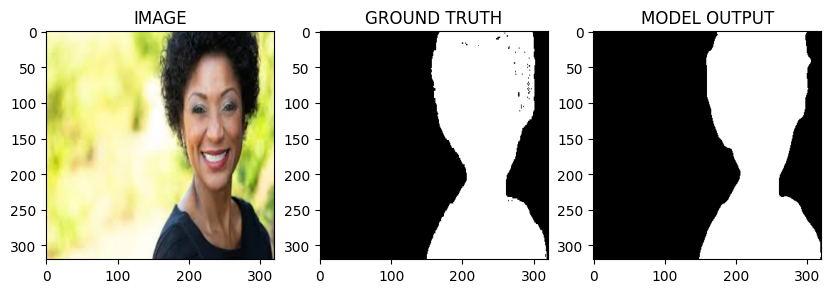

In [32]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya